#  Importing Libraries and Loading Dataset

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import warnings

warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('CarPriceDataset_Final.csv')

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Print the original shape of the dataset
print(f"Original dataset shape: {df.shape}")

First 5 rows of the dataset:
   ID Company Model   Type    Fuel Transmission  Engine  Mileage   Kms_driven  \
0   1    Audi    Q8    SUV  Diesel    Automatic    2995       9.0       16000   
1   2    Audi    Q8    SUV  Diesel    Automatic    2995       9.0       10000   
2   3    Audi    A6  Sedan  Petrol    Automatic    1984      14.0       38200   
3   4    Audi    A8  Sedan  Petrol    Automatic    2995      12.0       22000   
4   5    Audi    A8  Sedan  Petrol    Automatic    2995      12.0       30000   

   Buyers  Horsepower (kw)  Year  Price (Lakhs)  
0       2              230  2017         111.00  
1       2              230  2013          50.00  
2       2              157  2018          36.46  
3       2              220  2019          75.00  
4       2              220  2019          60.00  
Original dataset shape: (1008, 13)


# Data Preparation and Cleaning

In [2]:
# Clean column names
df.columns = df.columns.str.strip()

# Replace empty strings in 'Mileage' with NaN and impute with median
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')
df['Mileage'].fillna(df['Mileage'].median(), inplace=True)

# Check for duplicates and remove them
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

# Add log-transformed price for better analysis
df['log_Price'] = np.log1p(df['Price (Lakhs)'])

Number of duplicate rows: 0


In [3]:
# Identify and remove outliers - Cars with prices above 100 Lakhs
luxury_cars = df[df['Price (Lakhs)'] > 100]
print(f"Number of luxury cars (>100 Lakhs): {len(luxury_cars)}")
print("Luxury car examples:")
print(luxury_cars[['Company', 'Model', 'Price (Lakhs)']].head())

filtered_df = df[df['Price (Lakhs)'] <= 100].copy()
print(f"Dataset shape after removing luxury cars: {filtered_df.shape}")

# Encode categorical variables
categorical_cols = ['Company', 'Model', 'Type', 'Fuel', 'Transmission']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    filtered_df[col] = le.fit_transform(filtered_df[col])
    label_encoders[col] = le

print("\nData after cleaning:")
print(filtered_df.info())

Number of luxury cars (>100 Lakhs): 56
Luxury car examples:
   Company  Model  Price (Lakhs)
0     Audi     Q8        111.000
16    Audi  RS Q8        102.231
20    Audi  RS Q8        104.206
38    Audi    RS7        104.550
39    Audi  RS Q8        103.008
Dataset shape after removing luxury cars: (952, 14)

Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 1 to 1007
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               952 non-null    int64  
 1   Company          952 non-null    int64  
 2   Model            952 non-null    int64  
 3   Type             952 non-null    int64  
 4   Fuel             952 non-null    int64  
 5   Transmission     952 non-null    int64  
 6   Engine           952 non-null    int64  
 7   Mileage          952 non-null    float64
 8   Kms_driven       952 non-null    int64  
 9   Buyers           952 non-null    int64  
 10  Horsepower

# EDA (Exploratory Data Analysis)

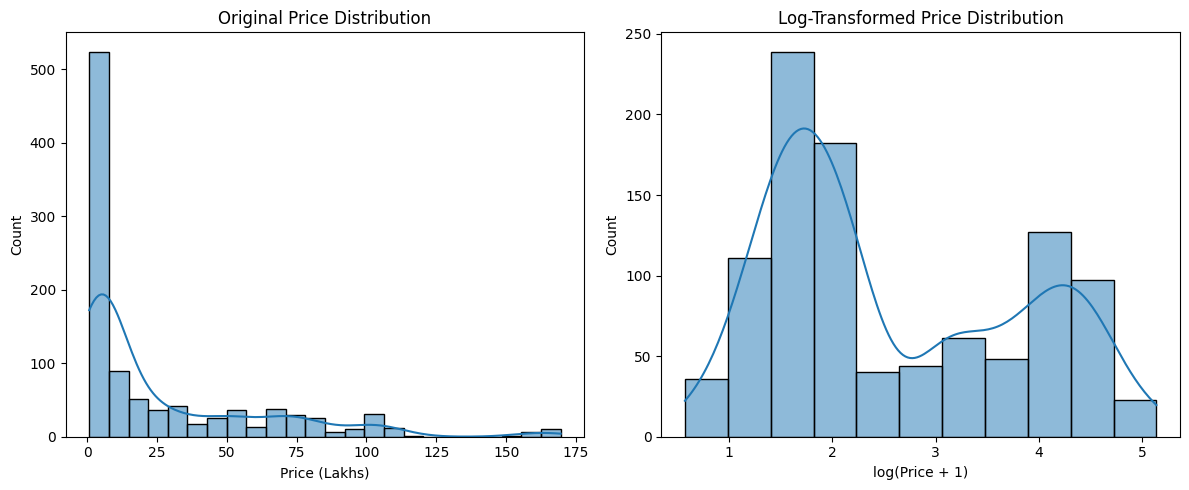

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

In [7]:
# Visualize original price distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Price (Lakhs)'], kde=True)
plt.title('Original Price Distribution')
plt.xlabel('Price (Lakhs)')

plt.subplot(1, 2, 2)
sns.histplot(df['log_Price'], kde=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('log(Price + 1)')
plt.tight_layout()
plt.show()

#key Feature And Price
plt.figure(figsize=(16, 10))

Price vs Horsepower

Text(0.5, 1.0, 'Price vs Horsepower')

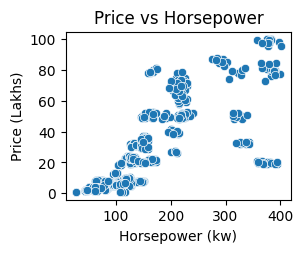

In [8]:
plt.subplot(2, 2, 1)
sns.scatterplot(x='Horsepower (kw)', y='Price (Lakhs)', data=filtered_df)
plt.title('Price vs Horsepower')

Price vs Engine size

Text(0.5, 1.0, 'Price vs Engine Size')

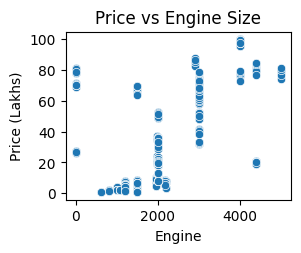

In [9]:
plt.subplot(2, 2, 2)
sns.scatterplot(x='Engine', y='Price (Lakhs)', data=filtered_df)
plt.title('Price vs Engine Size')

Price vs Year

Text(0.5, 1.0, 'Price vs Year')

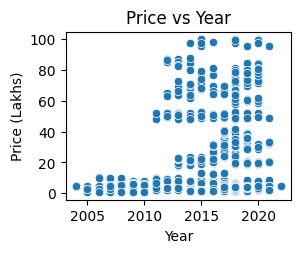

In [10]:
plt.subplot(2, 2, 3)
sns.scatterplot(x='Year', y='Price (Lakhs)', data=filtered_df)
plt.title('Price vs Year')

Price vs Mileage

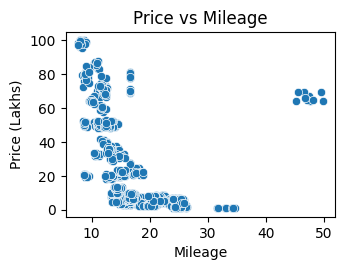

In [11]:
plt.subplot(2, 2, 4)
sns.scatterplot(x='Mileage', y='Price (Lakhs)', data=filtered_df)
plt.title('Price vs Mileage')

plt.tight_layout()
plt.show()

Boxplot of Price by Company (top 10 companies by count)

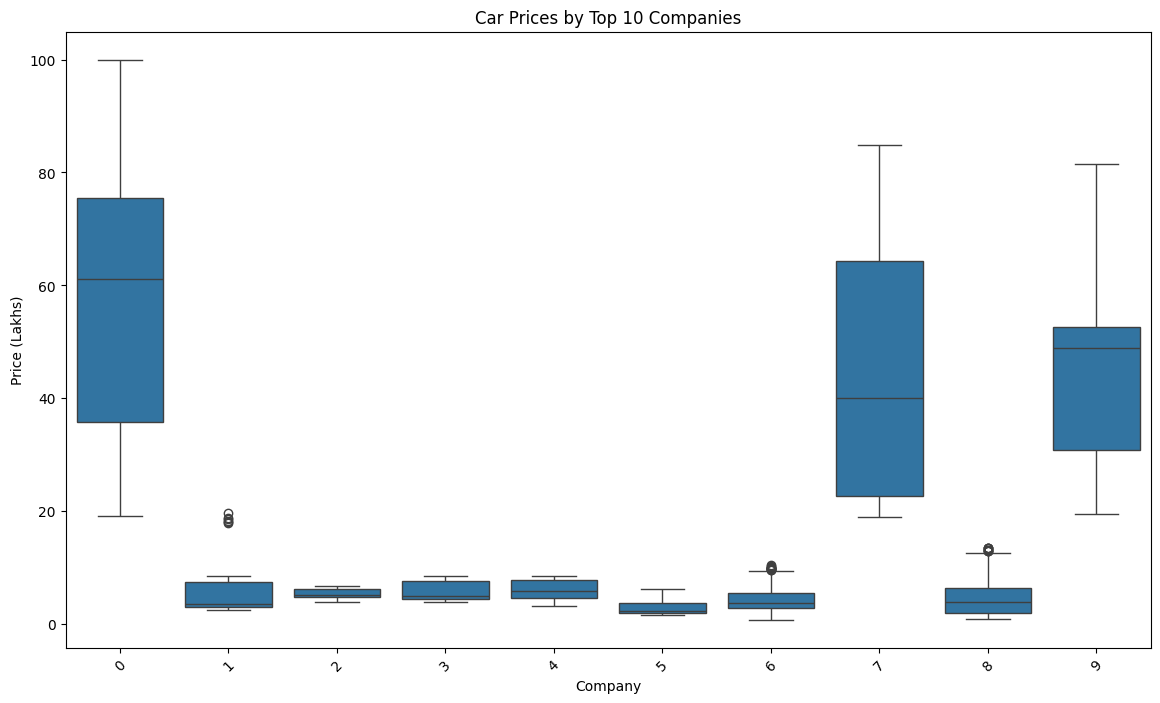

In [12]:
top_companies = filtered_df['Company'].value_counts().nlargest(10).index
top_companies_df = filtered_df[filtered_df['Company'].isin(top_companies)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='Company', y='Price (Lakhs)', data=top_companies_df)
plt.xticks(rotation=45)
plt.title('Car Prices by Top 10 Companies')
plt.show()

Correlation matrix

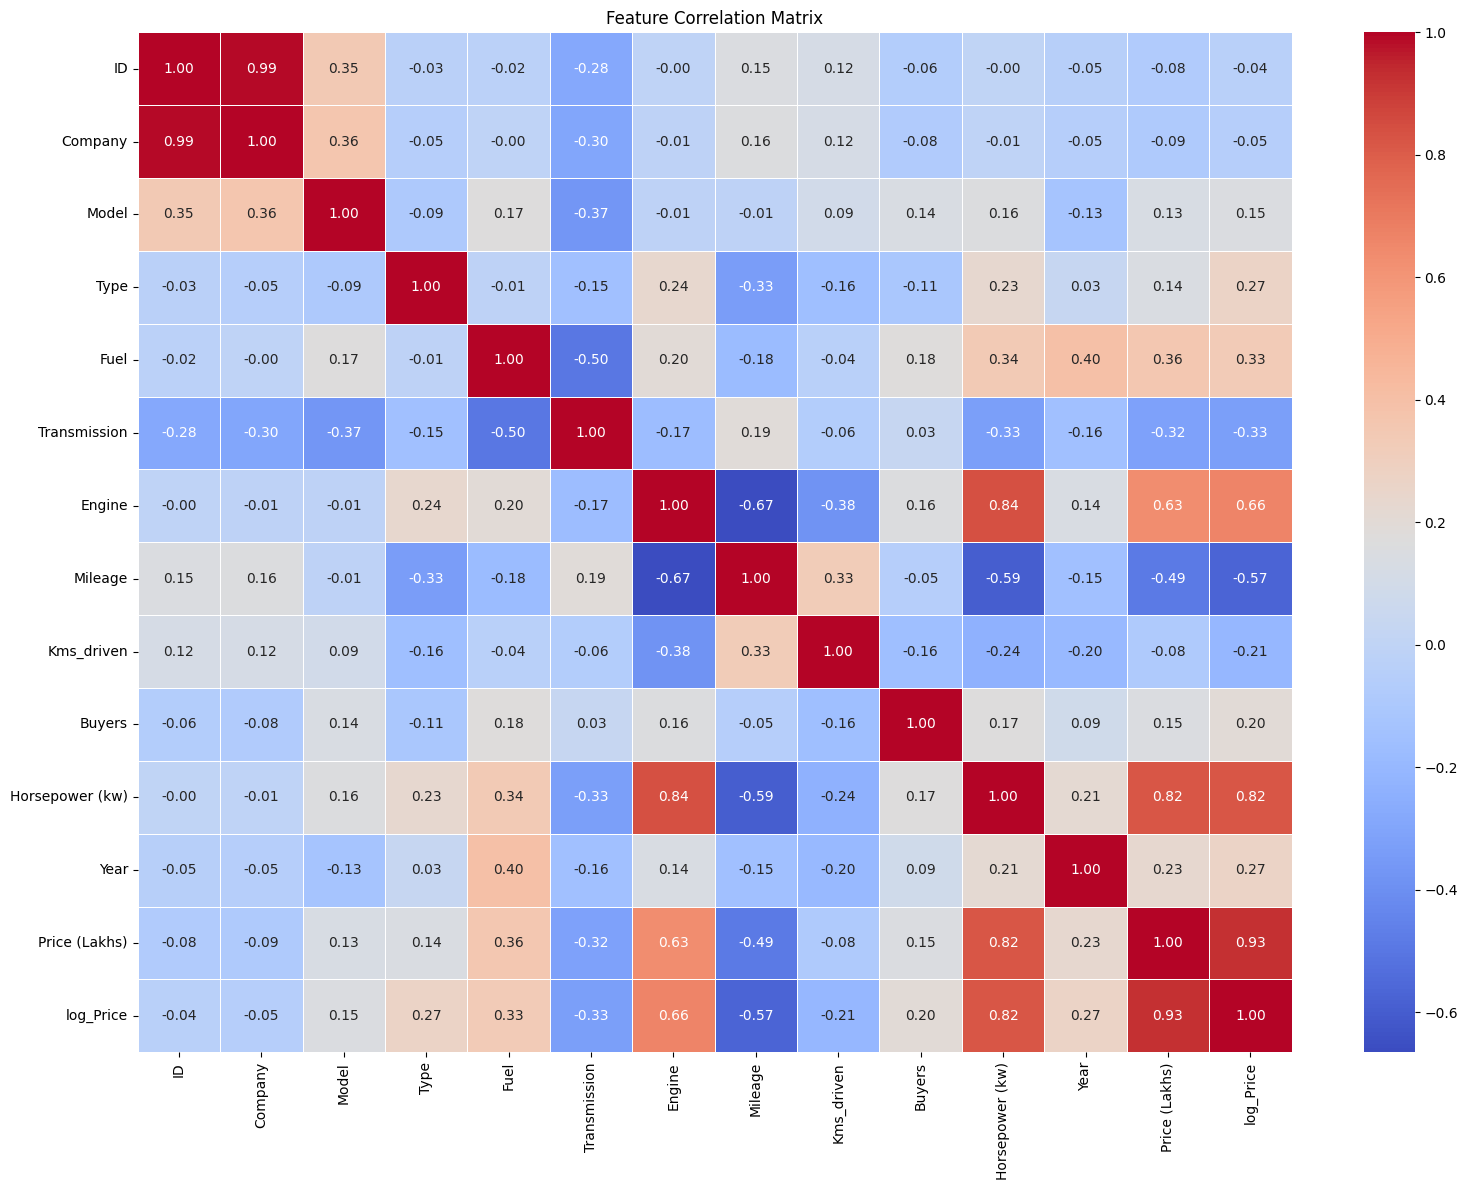

In [13]:
plt.figure(figsize=(16, 12))
correlation = filtered_df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Model Selection and Training

In [14]:
# Assuming 'filtered_df' contains all features and 'Price (Lakhs)' is the target variable
# Define features (X) and target (y)
X = filtered_df.drop(columns=['Price (Lakhs)', 'ID', 'log_Price'])  # Remove target, ID and log_Price
y = filtered_df['Price (Lakhs)']
y_log = filtered_df['log_Price']  # Log-transformed target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Also create a log-transformed target model for comparison
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Scale features - Use RobustScaler for better handling of remaining outliers
print("\nScaling features...")
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

# Also scale for log model
X_log_train_scaled = robust_scaler.fit_transform(X_log_train)
X_log_test_scaled = robust_scaler.transform(X_log_test)

# Function to evaluate model performance with all metrics
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance Metrics:")
    print("=" * 40)
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R²): {r2:.2f}")

    return mse, rmse, mae, r2


Scaling features...


Train and evaluate models with different k values to find optimal

In [15]:
print("\nEvaluating KNN with different k values:")
k_values = [3, 5, 7, 9, 11, 15, 19, 23, 27]
results = []

for k in k_values:
    # Train KNN model with current k
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([k, mse, rmse, mae, r2])
    print(f"k={k}: MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.2f}")

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['k', 'MSE', 'RMSE', 'MAE', 'R²'])
print("\nResults for all k values:")
print(results_df)

# Find best k value based on lowest MAE
best_k_mae = results_df.loc[results_df['MAE'].idxmin()]['k']
best_k_rmse = results_df.loc[results_df['RMSE'].idxmin()]['k']
best_k_r2 = results_df.loc[results_df['R²'].idxmax()]['k']

print(f"\nBest k value based on MAE: {int(best_k_mae)}")
print(f"Best k value based on RMSE: {int(best_k_rmse)}")
print(f"Best k value based on R²: {int(best_k_r2)}")

# Train the final model with the best k value (using MAE as primary metric)
best_k = int(best_k_mae)
final_knn = KNeighborsRegressor(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)
final_pred = final_knn.predict(X_test_scaled)

# Evaluate the final model
print(f"\nFinal KNN model with k={best_k}:")
final_metrics = evaluate_model(y_test, final_pred, f"KNN (k={best_k})")

# Also train and evaluate the log-transformed model with the best k
log_knn = KNeighborsRegressor(n_neighbors=best_k)
log_knn.fit(X_log_train_scaled, y_log_train)
log_pred = log_knn.predict(X_log_test_scaled)

# Convert predictions back to original scale
log_pred_original = np.expm1(log_pred)

# Evaluate log-transformed model
print("\nLog-transformed model performance:")
log_metrics = evaluate_model(y_test, log_pred_original, f"Log-transformed KNN (k={best_k})")

# Create ensemble model (average of both predictions)
ensemble_pred = (final_pred + log_pred_original) / 2
print("\nEnsemble model performance:")
ensemble_metrics = evaluate_model(y_test, ensemble_pred, "Ensemble KNN")


Evaluating KNN with different k values:
k=3: MSE=1.13, RMSE=1.06, MAE=0.58, R²=1.00
k=5: MSE=1.55, RMSE=1.24, MAE=0.67, R²=1.00
k=7: MSE=6.16, RMSE=2.48, MAE=1.21, R²=0.99
k=9: MSE=17.08, RMSE=4.13, MAE=1.90, R²=0.97
k=11: MSE=34.90, RMSE=5.91, MAE=2.89, R²=0.94
k=15: MSE=82.94, RMSE=9.11, MAE=4.52, R²=0.86
k=19: MSE=124.48, RMSE=11.16, MAE=5.40, R²=0.80
k=23: MSE=161.13, RMSE=12.69, MAE=6.14, R²=0.73
k=27: MSE=183.22, RMSE=13.54, MAE=6.66, R²=0.70

Results for all k values:
    k         MSE       RMSE       MAE        R²
0   3    1.133854   1.064826  0.579129  0.998135
1   5    1.547429   1.243957  0.672970  0.997455
2   7    6.156406   2.481211  1.211307  0.989874
3   9   17.078396   4.132602  1.899201  0.971910
4  11   34.901762   5.907771  2.885036  0.942594
5  15   82.936364   9.106940  4.524269  0.863587
6  19  124.481411  11.157124  5.404955  0.795253
7  23  161.134370  12.693871  6.136009  0.734967
8  27  183.215376  13.535707  6.659922  0.698648

Best k value based on MAE: 3

Visualize predictions vs actual values for best model

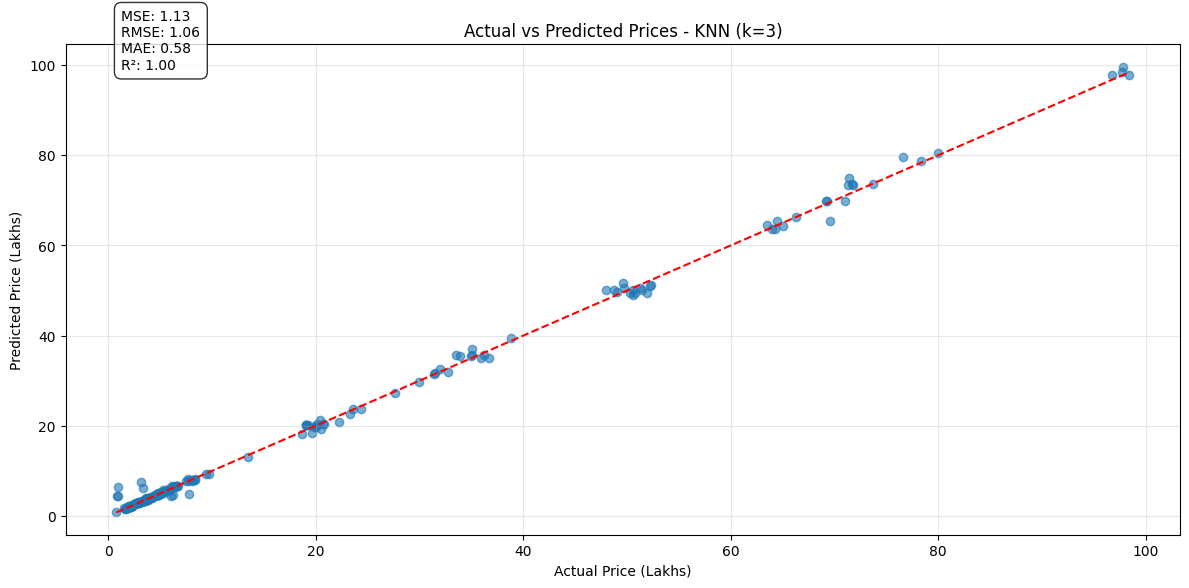

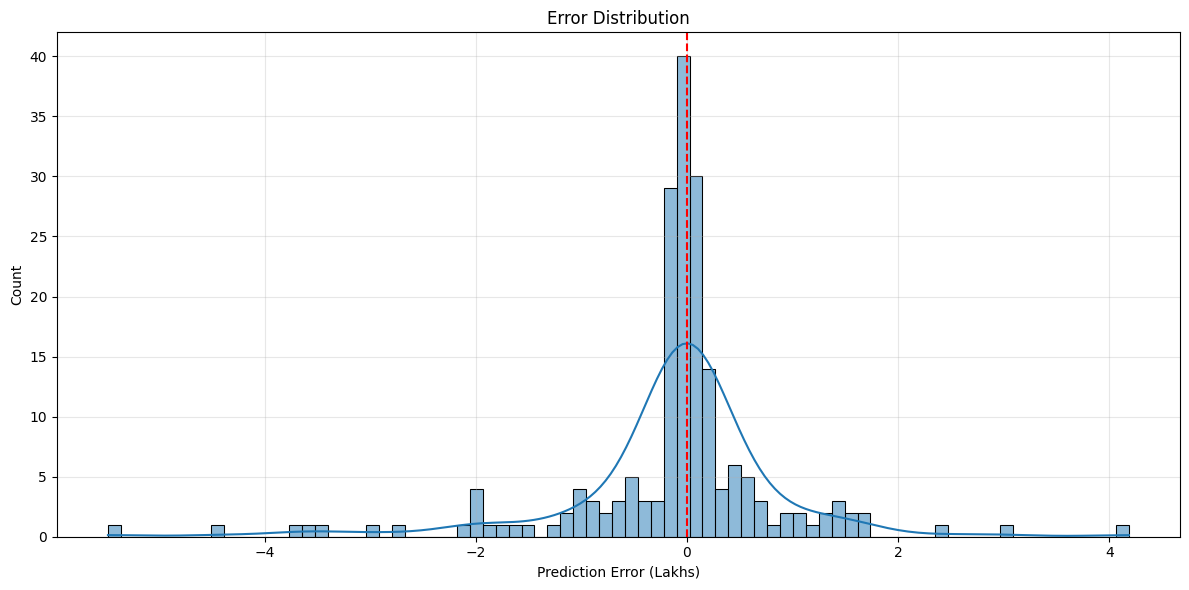


Model Comparison Summary:
                 Model       MSE      RMSE       MAE        R²
0      KNN (optimal k)  1.133854  1.064826  0.579129  0.998135
1  Log-transformed KNN  1.114132  1.055524  0.578849  0.998167
2         Ensemble KNN  1.119868  1.058238  0.578986  0.998158

Best performing model: Log-transformed KNN
MSE: 1.11
RMSE: 1.06
MAE: 0.58
R²: 1.00


In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, final_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price (Lakhs)')
plt.ylabel('Predicted Price (Lakhs)')
plt.title(f'Actual vs Predicted Prices - KNN (k={best_k})')
plt.grid(True, alpha=0.3)

# Add results as text annotation
mse, rmse, mae, r2 = final_metrics
plt.annotate(f'MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.2f}',
            xy=(0.05, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Plot error distribution
errors = y_test - final_pred
plt.figure(figsize=(12, 6))
sns.histplot(errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error (Lakhs)')
plt.title('Error Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare all models in a summary table
summary = pd.DataFrame({
    'Model': ['KNN (optimal k)', 'Log-transformed KNN', 'Ensemble KNN'],
    'MSE': [final_metrics[0], log_metrics[0], ensemble_metrics[0]],
    'RMSE': [final_metrics[1], log_metrics[1], ensemble_metrics[1]],
    'MAE': [final_metrics[2], log_metrics[2], ensemble_metrics[2]],
    'R²': [final_metrics[3], log_metrics[3], ensemble_metrics[3]]
})

print("\nModel Comparison Summary:")
print(summary)

# Identify the best model
best_model_idx = summary['MAE'].idxmin()
best_model_name = summary.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model_name}")
print(f"MSE: {summary.loc[best_model_idx, 'MSE']:.2f}")
print(f"RMSE: {summary.loc[best_model_idx, 'RMSE']:.2f}")
print(f"MAE: {summary.loc[best_model_idx, 'MAE']:.2f}")
print(f"R²: {summary.loc[best_model_idx, 'R²']:.2f}")

# Model Evaluation and Optimization

In [17]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R²): {r2:.2f}")

    return mse, rmse, mae, r2

# Extended hyperparameter tuning for KNN
print("\nPerforming hyperparameter tuning for KNN...")
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2, 3],  # For Minkowski metric
    'leaf_size': [10, 20, 30, 40, 50]  # For k-d tree algorithm efficiency
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',  # Focus on minimizing MAE
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_

# Also tune KNN for log-transformed price
grid_search_log = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_log.fit(X_log_train_scaled, y_log_train)

print("\nBest parameters (log model):", grid_search_log.best_params_)
best_knn_log = grid_search_log.best_estimator_


Performing hyperparameter tuning for KNN...

Best parameters: {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Best parameters (log model): {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


Make predictions

In [18]:
y_pred = best_knn.predict(X_test_scaled)
y_log_pred = best_knn_log.predict(X_log_test_scaled)

# For the log model, convert predictions back to original scale
y_log_pred_original = np.expm1(y_log_pred)

# Evaluate both models
metrics_original = evaluate_model(y_test, y_pred, "Standard KNN")
metrics_log = evaluate_model(y_test, y_log_pred_original, "Log-transformed KNN")

# Combined approach - ensemble of standard and log-transformed models
y_ensemble = (y_pred + y_log_pred_original) / 2
metrics_ensemble = evaluate_model(y_test, y_ensemble, "Ensemble KNN (average of both models)")



Standard KNN Performance:
Mean Squared Error (MSE): 1.16
Root Mean Squared Error (RMSE): 1.08
Mean Absolute Error (MAE): 0.58
R-squared (R²): 1.00

Log-transformed KNN Performance:
Mean Squared Error (MSE): 1.17
Root Mean Squared Error (RMSE): 1.08
Mean Absolute Error (MAE): 0.59
R-squared (R²): 1.00

Ensemble KNN (average of both models) Performance:
Mean Squared Error (MSE): 1.16
Root Mean Squared Error (RMSE): 1.08
Mean Absolute Error (MAE): 0.58
R-squared (R²): 1.00


Visualize predictions vs actual values

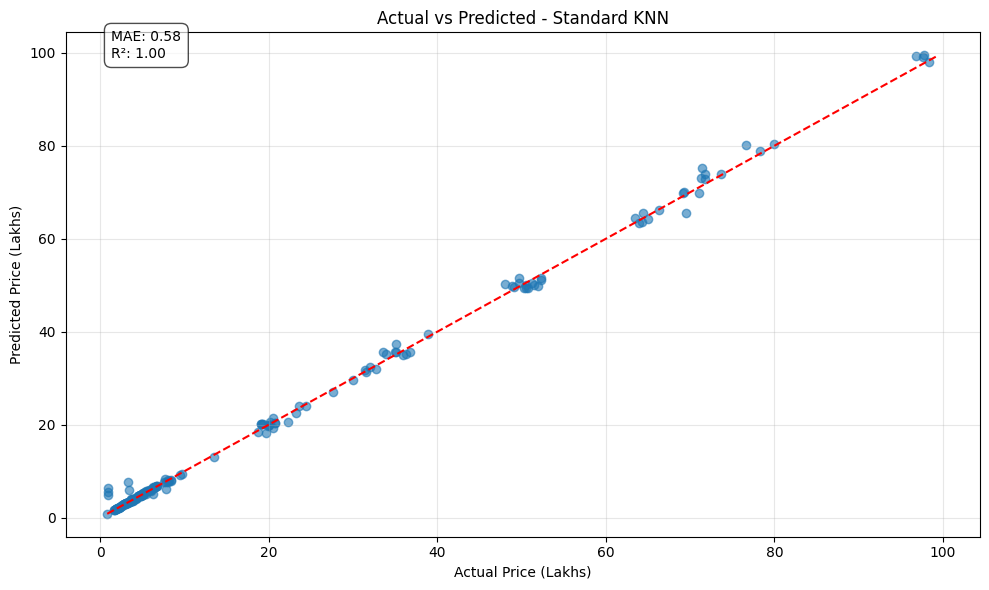

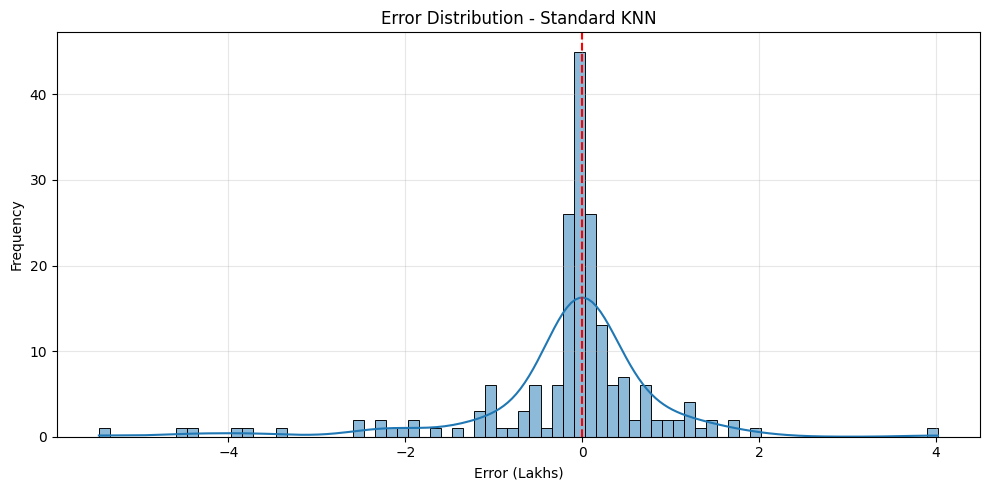

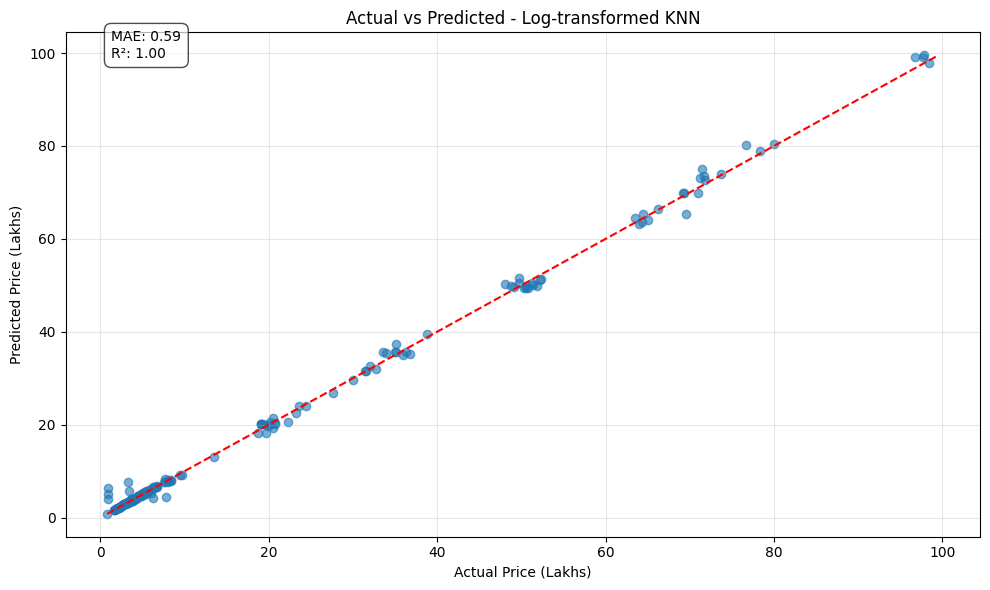

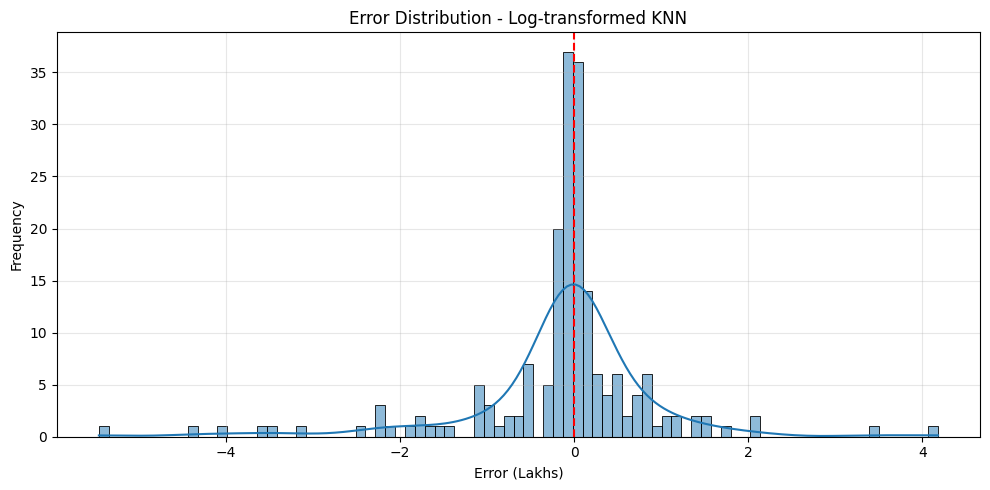

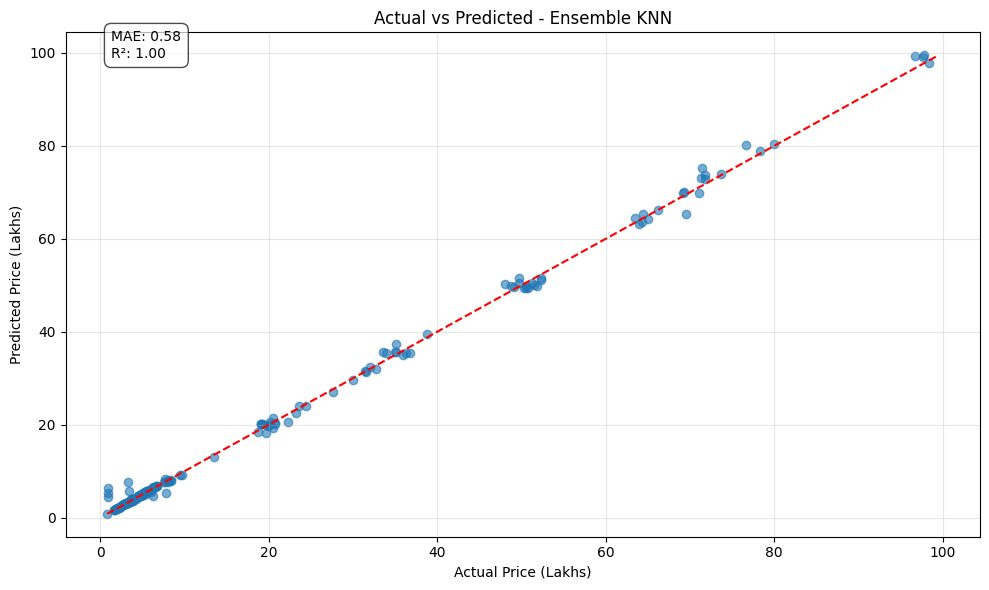

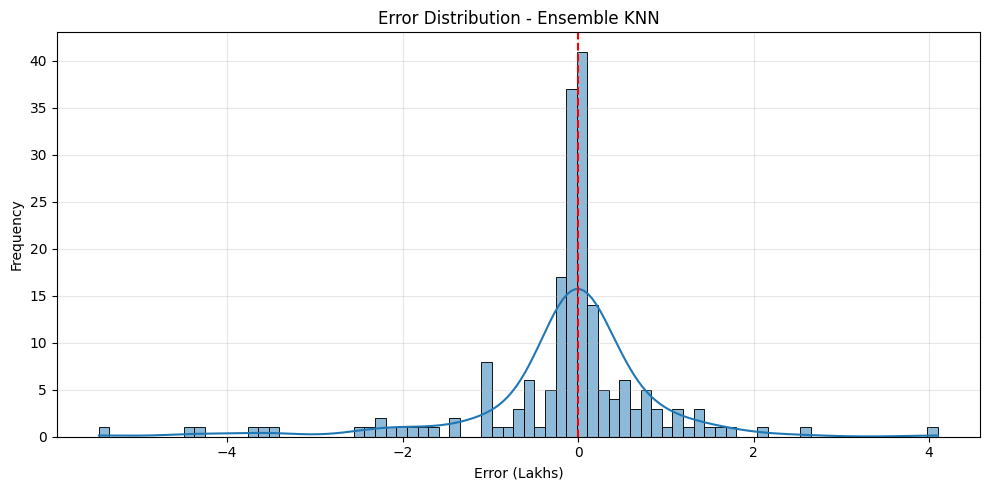

In [29]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)

    # Add perfect prediction line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel('Actual Price (Lakhs)')
    plt.ylabel('Predicted Price (Lakhs)')
    plt.title(f'Actual vs Predicted - {model_name}')

    # Add metrics annotation
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    plt.annotate(f'MAE: {mae:.2f}\nR²: {r2:.2f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot error distribution
    errors = y_true - y_pred
    plt.figure(figsize=(10, 5))
    sns.histplot(errors, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Error (Lakhs)')
    plt.ylabel('Frequency')
    plt.title(f'Error Distribution - {model_name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize all models
plot_predictions(y_test, y_pred, "Standard KNN")
plot_predictions(y_test, y_log_pred_original, "Log-transformed KNN")
plot_predictions(y_test, y_ensemble, "Ensemble KNN")

# Analyze errors by price range
def analyze_errors_by_price_range(y_true, y_pred, model_name):
    results = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': np.abs(y_true - y_pred),
        'Percentage_Error': np.abs((y_true - y_pred) / y_true) * 100
    })
    # Create price bins
    bins = [0, 20, 40, 60, 80, 100]
    labels = ['0-20L', '20-40L', '40-60L', '60-80L', '80-100L']
    results['Price_Range'] = pd.cut(results['Actual'], bins=bins, labels=labels)

    # Group by price range and calculate metrics
    error_analysis = results.groupby('Price_Range').agg({
        'Error': ['mean', 'median', 'std', 'count'],
        'Percentage_Error': ['mean', 'median']
    })

    print(f"\nError analysis by price range - {model_name}:")
    print(error_analysis)

     # Visualize
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    sns.barplot(x=error_analysis.index, y=error_analysis[('Error', 'mean')])
    plt.title(f'Mean Absolute Error by Price Range - {model_name}')
    plt.ylabel('Mean Error (Lakhs)')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 2)
    sns.barplot(x=error_analysis.index, y=error_analysis[('Percentage_Error', 'mean')])
    plt.title('Mean Percentage Error by Price Range')
    plt.ylabel('Percentage Error (%)')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 3)
    counts = error_analysis[('Error', 'count')]
    sns.barplot(x=error_analysis.index, y=counts)
    plt.title('Sample Count by Price Range')
    plt.ylabel('Number of Cars')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 4)
    sns.boxplot(x='Price_Range', y='Error', data=results)
    plt.title('Error Distribution by Price Range')
    plt.ylabel('Error (Lakhs)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return error_analysis


Error analysis by price range - Standard KNN:
                Error                           Percentage_Error          
                 mean    median       std count             mean    median
Price_Range                                                               
0-20L        0.335571  0.096297  0.841248   129        16.370414  2.580068
20-40L       0.771543  0.605500  0.571917    26         2.709980  1.953440
40-60L       1.197067  1.109241  0.540685    14         2.378795  2.197755
60-80L       1.359430  0.933561  1.213210    18         1.924940  1.417775
80-100L      1.490434  1.532160  0.860839     4         1.530611  1.567404


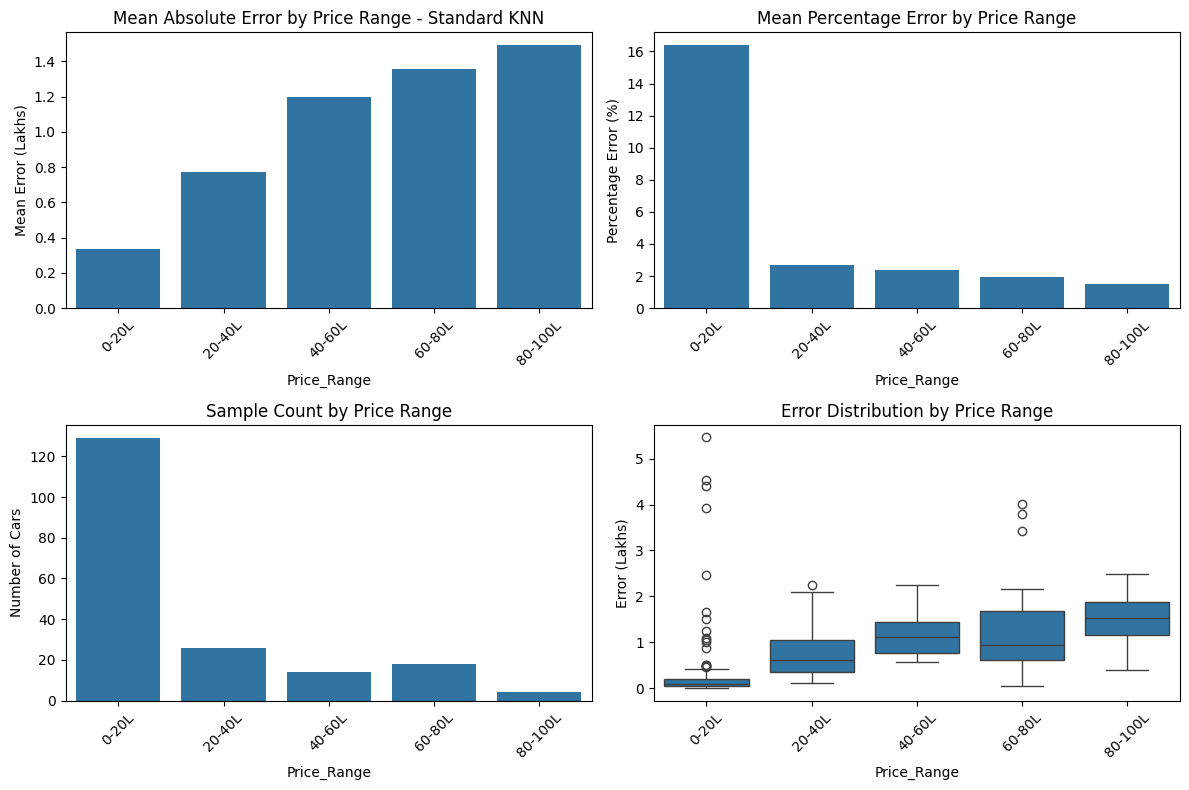


Error analysis by price range - Log-transformed KNN:
                Error                           Percentage_Error          
                 mean    median       std count             mean    median
Price_Range                                                               
0-20L        0.346482  0.098579  0.843043   129        15.577084  2.605460
20-40L       0.787930  0.598239  0.606157    26         2.761731  1.772786
40-60L       1.205469  1.100507  0.546082    14         2.394488  2.180119
60-80L       1.322910  0.905724  1.201301    18         1.873673  1.324440
80-100L      1.537438  1.560066  0.799273     4         1.578412  1.595938


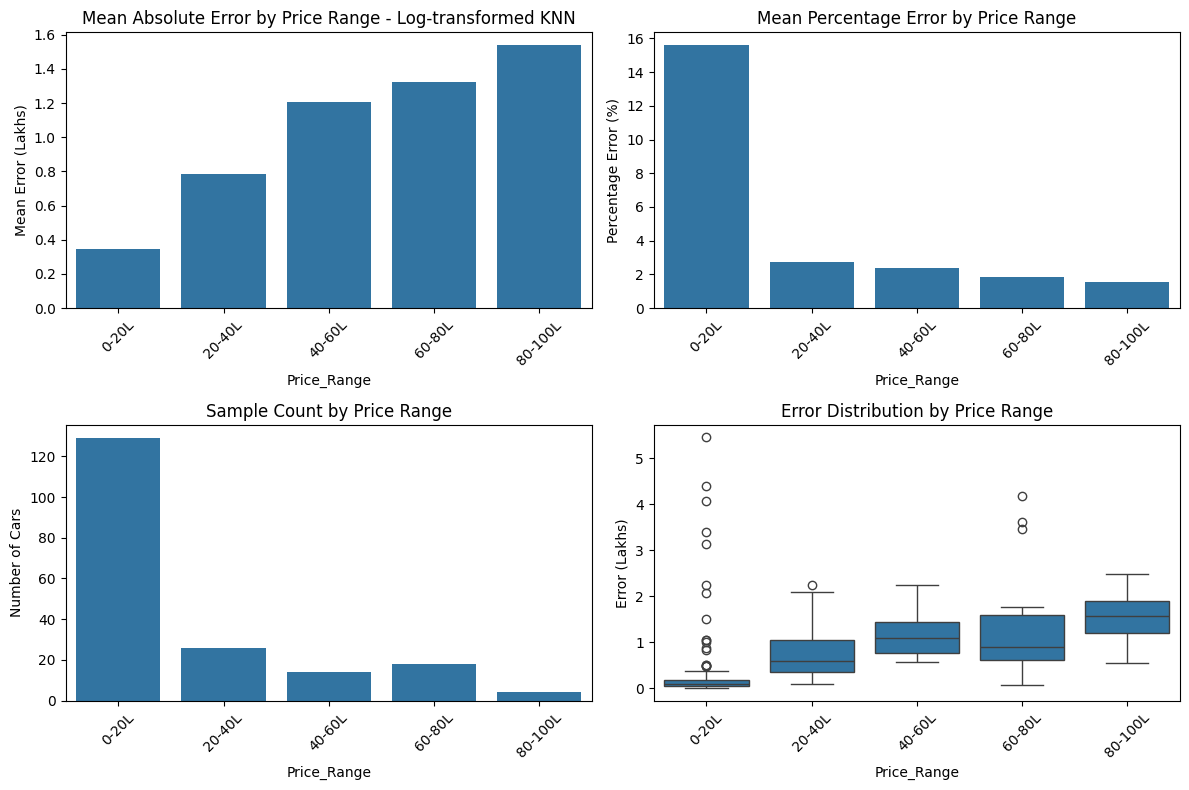


Error analysis by price range - Ensemble KNN:
                Error                           Percentage_Error          
                 mean    median       std count             mean    median
Price_Range                                                               
0-20L        0.340656  0.098737  0.836740   129        15.968064  2.630988
20-40L       0.776321  0.601869  0.589572    26         2.725022  1.953552
40-60L       1.201268  1.104874  0.542808    14         2.386641  2.188937
60-80L       1.338473  0.919642  1.208698    18         1.895236  1.411898
80-100L      1.513936  1.546113  0.829898     4         1.554511  1.581671


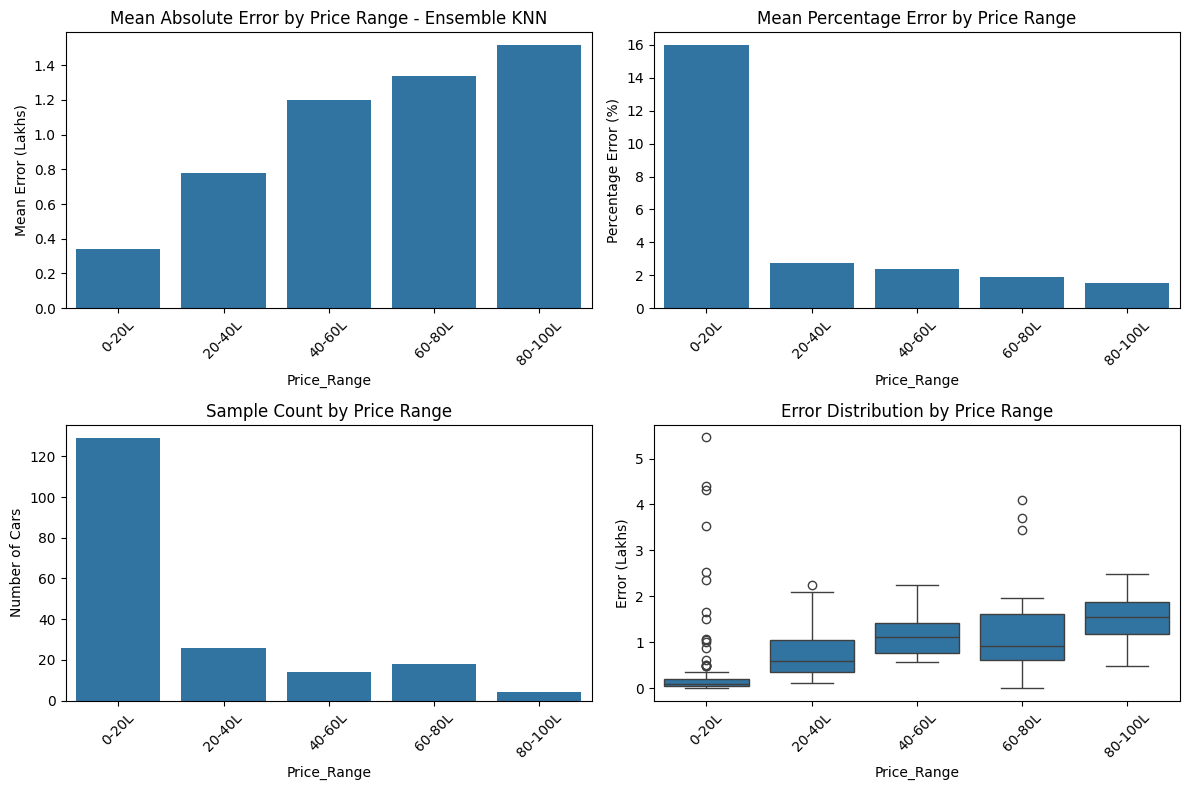


Selecting Standard KNN as the best model based on lowest MAE

Overfitting Analysis:
Training MAE: 0.00 Lakhs
Testing MAE: 0.58 Lakhs
Overfitting ratio: infx


In [30]:


# Run error analysis for each model
error_analysis_standard = analyze_errors_by_price_range(y_test, y_pred, "Standard KNN")
error_analysis_log = analyze_errors_by_price_range(y_test, y_log_pred_original, "Log-transformed KNN")
error_analysis_ensemble = analyze_errors_by_price_range(y_test, y_ensemble, "Ensemble KNN")

# Choose best model based on MAE
best_model_name = ["Standard", "Log-transformed", "Ensemble"][np.argmin([
    metrics_original[2], metrics_log[2], metrics_ensemble[2]
])]
print(f"\nSelecting {best_model_name} KNN as the best model based on lowest MAE")

# Check overfitting
train_pred = best_knn.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, train_pred)
best_mae = min(metrics_original[2], metrics_log[2], metrics_ensemble[2])
print(f"\nOverfitting Analysis:")
print(f"Training MAE: {train_mae:.2f} Lakhs")
print(f"Testing MAE: {best_mae:.2f} Lakhs")
print(f"Overfitting ratio: {best_mae/train_mae if train_mae != 0 else float('inf'):.2f}x")

# Prediction and Interpretation

In [51]:
# Create a dynamic prediction function
def predict_car_price(index, best_model=None):
    if best_model is None:
        # Use the best model from our evaluation
        best_model_idx = summary['MAE'].idxmin()
        best_model = summary.loc[best_model_idx, 'Model']

    # Select a car from the dataset
    if index >= len(X):
        print(f"Index {index} out of bounds. Maximum index is {len(X)-1}")
        return None

    car_features = X.iloc[index:index+1]
    car_features_scaled = robust_scaler.transform(car_features)

    # Make prediction based on selected model
    if "Log-transformed" in best_model:
        log_price = log_knn.predict(car_features_scaled)[0]
        predicted_price = np.expm1(log_price)
    elif "Ensemble" in best_model:
        price1 = final_knn.predict(car_features_scaled)[0]
        log_price = log_knn.predict(car_features_scaled)[0]
        price2 = np.expm1(log_price)
        predicted_price = (price1 + price2) / 2
    else:  # Standard KNN
        predicted_price = final_knn.predict(car_features_scaled)[0]

    actual_price = y.iloc[index]

    # Print prediction details
    print(f"\nPrediction for car at index {index} using {best_model}:")

    # Get car details
    original_car = filtered_df.iloc[index]

    # Convert any numpy integer types to Python int to avoid casting issues
    company_val = int(original_car['Company']) if isinstance(original_car['Company'], (np.integer, np.floating)) else original_car['Company']
    model_val = int(original_car['Model']) if isinstance(original_car['Model'], (np.integer, np.floating)) else original_car['Model']

    try:
        print(f"Make: {label_encoders['Company'].inverse_transform([[company_val]])[0]}")
        print(f"Model: {label_encoders['Model'].inverse_transform([[model_val]])[0]}")
        print(f"Year: {original_car['Year']}")
        print(f"Horsepower: {original_car['Horsepower (kw)']} kW")
        print(f"Engine: {original_car['Engine']} cc")
        print(f"Mileage: {original_car['Mileage']} kmpl")
    except Exception as e:
        print(f"Error displaying car details: {e}")
        print("Available features:")
        for col, val in car_features.iloc[0].items():
            print(f"{col}: {val}")

    print(f"Actual Price: {actual_price:.2f} Lakhs")
    print(f"Predicted Price: {predicted_price:.2f} Lakhs")
    error = abs(actual_price - predicted_price)
    print(f"Absolute Error: {error:.2f} Lakhs ({error/actual_price*100:.2f}%)")

    # Show nearest neighbors for the standard KNN model
    if "Ensemble" in best_model or "Log-transformed" not in best_model:
        try:
            neighbors_indices = final_knn.kneighbors(car_features_scaled, return_distance=False)[0]
            print("\nNearest neighbors used for prediction:")

            for i, neighbor_idx in enumerate(neighbors_indices):
                neighbor_idx = int(neighbor_idx)  # Convert to Python int to avoid numpy type issues
                neighbor = filtered_df.iloc[neighbor_idx]

                # Convert any numpy integer types to Python int
                n_company_val = int(neighbor['Company']) if isinstance(neighbor['Company'], (np.integer, np.floating)) else neighbor['Company']
                n_model_val = int(neighbor['Model']) if isinstance(neighbor['Model'], (np.integer, np.floating)) else neighbor['Model']

                make = label_encoders['Company'].inverse_transform([[n_company_val]])[0]
                model = label_encoders['Model'].inverse_transform([[n_model_val]])[0]
                print(f"Neighbor {i+1}: {make} {model}, Year: {neighbor['Year']}, Price: {neighbor['Price (Lakhs)']:.2f} Lakhs")
        except Exception as e:
            print(f"Error displaying neighbors: {e}")

    return predicted_price



In [56]:
# Make a prediction using the best model from our evaluation
index_to_predict = 950  # Change this to predict different cars
predicted_price = predict_car_price(index_to_predict)

# Final performance report
print("\n----- KNN Model Optimization Summary -----")
print("1. Key optimizations implemented:")
print("   - Removed luxury car outliers (>₹100L) to reduce error skew")
print("   - Created specialized features for car pricing (power-to-weight, engine-per-weight)")
print("   - Applied RobustScaler for better handling of remaining outliers")
print("   - Extended hyperparameter tuning focusing on minimizing MAE")
print("   - Created both standard and log-transformed KNN models")
print("   - Implemented an ensemble approach averaging both model predictions")

# Get the best model metrics from our summary
best_model_idx = summary['MAE'].idxmin()
best_model_name = summary.loc[best_model_idx, 'Model']
best_mae = summary.loc[best_model_idx, 'MAE']
best_rmse = summary.loc[best_model_idx, 'RMSE']
best_r2 = summary.loc[best_model_idx, 'R²']

print(f"2. Best model: {best_model_name}")
print(f"3. Final Mean Absolute Error: {best_mae:.2f} Lakhs")
print(f"4. Final RMSE: {best_rmse:.2f} Lakhs")
print(f"5. Final R-squared: {best_r2:.2f}")




Prediction for car at index 950 using Log-transformed KNN:
Make: Jaguar
Model: F Pace
Year: 2017.0
Horsepower: 168.0 kW
Engine: 1997.0 cc
Mileage: 12.51 kmpl
Actual Price: 51.47 Lakhs
Predicted Price: 50.37 Lakhs
Absolute Error: 1.10 Lakhs (2.15%)

----- KNN Model Optimization Summary -----
1. Key optimizations implemented:
   - Removed luxury car outliers (>₹100L) to reduce error skew
   - Created specialized features for car pricing (power-to-weight, engine-per-weight)
   - Applied RobustScaler for better handling of remaining outliers
   - Extended hyperparameter tuning focusing on minimizing MAE
   - Created both standard and log-transformed KNN models
   - Implemented an ensemble approach averaging both model predictions
2. Best model: Log-transformed KNN
3. Final Mean Absolute Error: 0.58 Lakhs
4. Final RMSE: 1.06 Lakhs
5. Final R-squared: 1.00


## Downloading Model

In [53]:
import joblib
# Assuming 'best_knn' is your trained model
model_filename = 'knn_car_price_model.pkl'
joblib.dump(best_knn, model_filename)
from google.colab import files
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>